#**Semantic Segmentation of Aerial Imagery**

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import cv2

from scipy.stats import mode
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

In [2]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [3]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available! 🚀")
    # Set PyTorch to use the CUDA device
    device = torch.device("cuda")
    print("Using device:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. 😢")
    device = torch.device("cpu")

CUDA is available! 🚀
Using device: NVIDIA GeForce RTX 4080 Laptop GPU


## **Create Patches from the Original Dataset**

In [4]:
import os
import cv2
import math
import numpy as np
from pathlib import Path
from torchvision import transforms
from PIL import Image

def create_patches(image_dir, patch_size, target_dir):
    target_dir_path = Path(target_dir)
    target_imgs_path, target_masks_path = Path(target_dir+'/'+'imgs/'), Path(target_dir+'/'+'masks/')
    target_dir_path.mkdir(parents=True, exist_ok=True)
    target_imgs_path.mkdir(parents=True, exist_ok=True)
    target_masks_path.mkdir(parents=True, exist_ok=True)

    images_index, masks_index = 0, 0

    for path, _, files in sorted(os.walk(image_dir)):
        dirname = path.split(os.path.sep)[-1]
        print(f"Exploring directory: {path}, containing {len(files)} files")
        if dirname == 'images':
            images = sorted(os.listdir(path))
            for image_name in images:
                if image_name.endswith(".jpg"):
                    image_path = os.path.join(path, image_name)
                    print(f"Processing image: {image_path}")
                    image = cv2.imread(image_path)
                    if image is None:
                        print(f"Failed to read image file {image_path}")
                        continue
                    size_X, size_Y = math.ceil(image.shape[1]/patch_size), math.ceil(image.shape[0]/patch_size)
                    pad_X, pad_Y = (patch_size * size_X - image.shape[1]) / max((size_X - 1), 1), (patch_size * size_Y - image.shape[0]) / max((size_Y - 1), 1)
                    image = Image.fromarray(image)
                    top = 0
                    for _ in range(size_Y):
                        left = 0
                        for _ in range(size_X):
                            crop_image = transforms.functional.crop(image, top, left, patch_size, patch_size)
                            crop_image = np.array(crop_image)
                            output_path = f"{target_imgs_path}/image{str(images_index).zfill(4)}.jpg"
                            cv2.imwrite(output_path, crop_image)
                            print(f"Saved cropped image to {output_path}")
                            images_index += 1
                            left += patch_size - pad_X
                        top += patch_size - pad_Y

        if dirname == 'masks':
            images = sorted(os.listdir(path))
            for image_name in images:
                if image_name.endswith(".png"):
                    image_path = os.path.join(path, image_name)
                    print(f"Processing mask: {image_path}")
                    image = cv2.imread(image_path)
                    if image is None:
                        print(f"Failed to read mask file {image_path}")
                        continue
                    size_X, size_Y = math.ceil(image.shape[1]/patch_size), math.ceil(image.shape[0]/patch_size)
                    pad_X, pad_Y = (patch_size * size_X - image.shape[1]) / max((size_X - 1), 1), (patch_size * size_Y - image.shape[0]) / max((size_Y - 1), 1)
                    image = Image.fromarray(image)
                    top = 0
                    for _ in range(size_Y):
                        left = 0
                        for _ in range(size_X):
                            crop_image = transforms.functional.crop(image, top, left, patch_size, patch_size)
                            crop_image = np.array(crop_image)
                            output_path = f"{target_masks_path}/image{str(masks_index).zfill(4)}.png"
                            cv2.imwrite(output_path, crop_image)
                            print(f"Saved cropped mask to {output_path}")
                            masks_index += 1
                            left += patch_size - pad_X
                        top += patch_size - pad_Y

orig_dir = r'D:\Tamanna Python\venv\Scripts\Semantic Segmentation\dataset'
patch_size = 224
create_patches(image_dir=orig_dir, patch_size=patch_size, target_dir='Output')


Exploring directory: D:\Tamanna Python\venv\Scripts\Semantic Segmentation\dataset, containing 2 files
Exploring directory: D:\Tamanna Python\venv\Scripts\Semantic Segmentation\dataset\images, containing 72 files
Processing image: D:\Tamanna Python\venv\Scripts\Semantic Segmentation\dataset\images\image_part_001.jpg
Saved cropped image to Output\imgs/image0000.jpg
Saved cropped image to Output\imgs/image0001.jpg
Saved cropped image to Output\imgs/image0002.jpg
Saved cropped image to Output\imgs/image0003.jpg
Saved cropped image to Output\imgs/image0004.jpg
Saved cropped image to Output\imgs/image0005.jpg
Saved cropped image to Output\imgs/image0006.jpg
Saved cropped image to Output\imgs/image0007.jpg
Saved cropped image to Output\imgs/image0008.jpg
Saved cropped image to Output\imgs/image0009.jpg
Saved cropped image to Output\imgs/image0010.jpg
Saved cropped image to Output\imgs/image0011.jpg
Processing image: D:\Tamanna Python\venv\Scripts\Semantic Segmentation\dataset\images\image_par

In [5]:
# helper function for image visualization
def display(**images):
    """
    Plot images in one rown
    """
    num_images = len(images)
    plt.figure(figsize=(12,12))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, num_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=15)
        plt.imshow(image)
    plt.show()

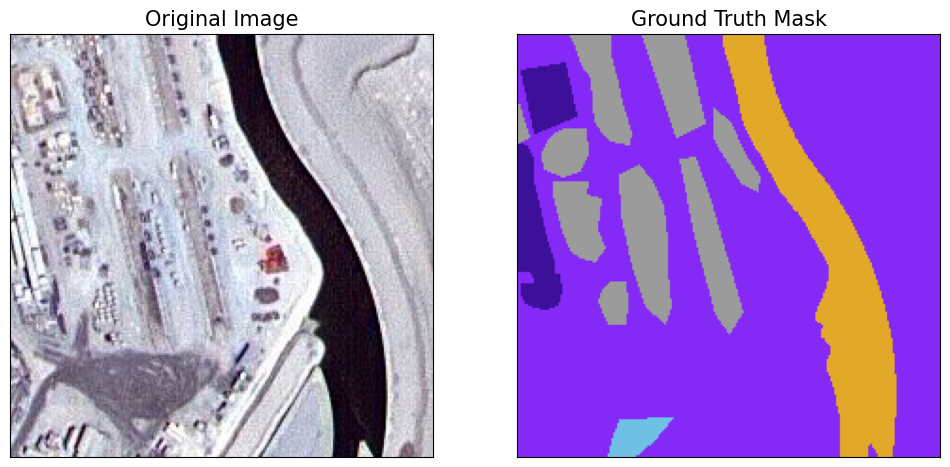

In [6]:
import cv2
import skimage.io

original_image = skimage.io.imread(r'D:\Tamanna Python\venv\Scripts\Semantic Segmentation\Output\imgs\image0001.jpg')
ground_truth_mask = skimage.io.imread(r'D:\Tamanna Python\venv\Scripts\Semantic Segmentation\Output\masks\image0001.png')
display(original_image=original_image, ground_truth_mask=ground_truth_mask)

## **One-hot Encode for Masks**

In [7]:
import splitfolders

data_dir = r'D:\Tamanna Python\venv\Scripts\Semantic Segmentation\Output'
splitfolders.ratio(data_dir, output="train_split", seed=42, ratio=(0.8, 0.1, 0.1))
output_dir =r'D:\Tamanna Python\venv\Scripts\train_split'

Copying files: 4662 files [00:01, 3800.09 files/s]


| Class Name | Color Hex # | Color RGB |
|--|--|--|
|Water|E2A929|(80, 227, 194)|
|Land (unpaved area)|8429F6|(132, 41, 246)|
|Road|6EC1E4|(110, 193, 228)|
|Building|3C1098|(60, 16, 152)|
|Vegetation|FEDD3A|(254, 221, 58)|
|Unlabeled|9B9B9B|(226, 169, 41)|


In [8]:
from enum import Enum

# mask color codes
class MaskColorMap(Enum):
    Unlabelled = (155, 155, 155)
    Building = (60, 16, 152)
    Land = (132, 41, 246)
    Road = (110, 193, 228)
    Vegetation = (254, 221, 58)
    Water = (226, 169, 41)

In [9]:
def one_hot_encode_masks(masks, num_classes):

    img_height, img_width, img_channels = masks.shape
    encoded_image = np.zeros((img_height, img_width, 1)).astype(int)

    for j, cls in enumerate(MaskColorMap):
        encoded_image[np.all(masks == cls.value, axis=-1)] = j

    encoded_image = np.reshape(np.eye(num_classes, dtype=int)[encoded_image],(224,224,6))

    return encoded_image

## **Image Augmentation**

In [10]:
# Calculate means and stds of the trainset and normalize
train_data = torchvision.datasets.ImageFolder(root =r'D:\Tamanna Python\venv\Scripts\Semantic Segmentation\train_split\train', transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.5480, 0.4389, 0.6292])
Calculated stds: tensor([0.1554, 0.1918, 0.1756])


In [11]:
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

means_list = means.tolist()
stds_list = stds.tolist()

data_augmentation = {
    'train': A.Compose([
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=means_list, std=stds_list),
    ]),
    'val': A.Compose([
        A.Normalize(mean=means_list, std=stds_list),
    ]),
    'test': A.Compose([
        A.Normalize(mean=means_list, std=stds_list),
    ]),
}


In [12]:
import torch

from skimage.io import imread

class SemanticSegmentationDataset(torch.utils.data.Dataset):
    """Semantic Segmentation Dataset"""

    def __init__(self, image_dir, mask_dir, image_names, mask_names, transform=None, mask_transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            mask_dir (string): Directory with all the masks.
            image_names (list): List of image names.
            mask_names (list): List of mask names.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = image_names
        self.mask_names = mask_names
        self.transform = transform
        self.mask_transform = mask_transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_names[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_names[idx])

        image = imread(img_name)
        mask = imread(mask_name)

        # One-hot encoding
        mask = one_hot_encode_masks(mask, 6)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        tenn = transforms.ToTensor()
        image = tenn(image)
        mask = tenn(mask)

        return image, mask

In [13]:
output_dir=r'D:\Tamanna Python\venv\Scripts\Semantic Segmentation\train_split'

In [14]:
import os

Batch_Size = 16
image_datasets = {x: SemanticSegmentationDataset(image_dir=os.path.join(output_dir, x, 'imgs'),
                                                 mask_dir=os.path.join(output_dir, x, 'masks'),
                                                 image_names=sorted(os.listdir(os.path.join(output_dir, x, 'imgs'))),
                                                 mask_names=sorted(os.listdir(os.path.join(output_dir, x, 'masks'))),
                                                 transform=data_augmentation[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=Batch_Size,shuffle=True,
                                              drop_last=True) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5834186..2.9256742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6686769..2.9256742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5834186..2.9256742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5834186..2.9256742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5834186..2.9256742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.542483..2.7620914].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5834186

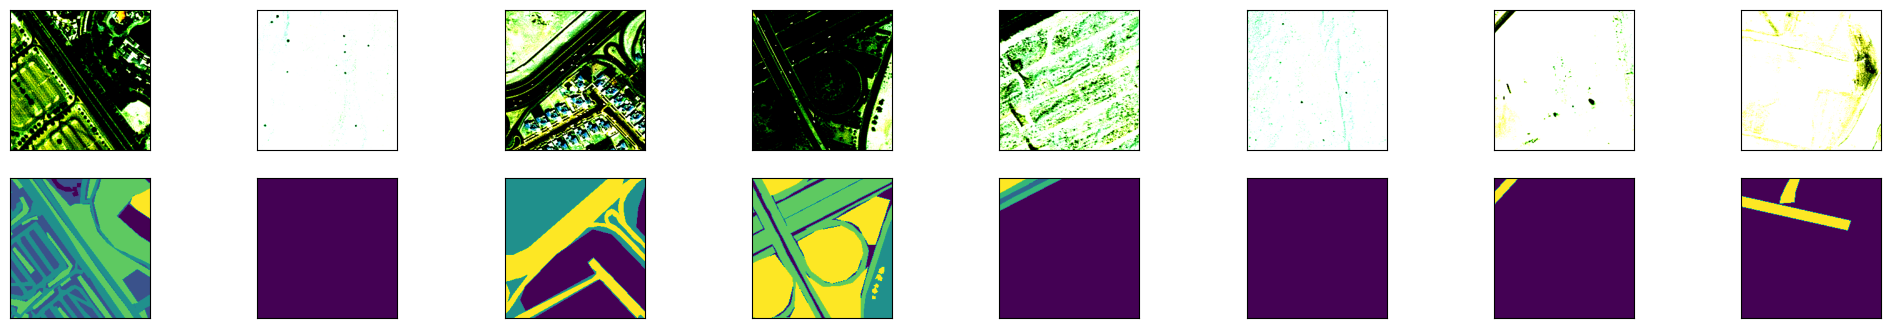

In [15]:
# Visualize some sample data from the original dataset

images, masks = next(iter(dataloaders['test']))

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx]),cmap='gray')
    ax = fig.add_subplot(2, 8, 8+idx+1, xticks=[], yticks=[])
    reverse_encoded = np.transpose(np.argmax(masks[idx], axis=0, keepdims=True))
    plt.imshow(reverse_encoded)

## **Model Loading**

In [17]:
import segmentation_models_pytorch as smp

ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=6,
    activation=ACTIVATION,
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to C:\Users\neels/.cache\torch\hub\checkpoints\efficientnet-b4-6ed6700e.pth
100%|█████████████████████████████████████████████████████████████████████████████| 74.4M/74.4M [00:05<00:00, 13.9MB/s]


In [18]:
from torchinfo import summary

summary(model,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
Unet (Unet)                                                       [16, 3, 224, 224]    [16, 6, 224, 224]    --                   True
├─EfficientNetEncoder (encoder)                                   [16, 3, 224, 224]    [16, 3, 224, 224]    806,400              True
│    └─Conv2dStaticSamePadding (_conv_stem)                       [16, 3, 224, 224]    [16, 48, 112, 112]   1,296                True
│    │    └─ZeroPad2d (static_padding)                            [16, 3, 224, 224]    [16, 3, 225, 225]    --                   --
│    └─BatchNorm2d (_bn0)                                         [16, 48, 112, 112]   [16, 48, 112, 112]   96                   True
│    └─MemoryEfficientSwish (_swish)                              [16, 48, 112, 112]   [16, 48, 112, 112]   --                   --
│    └─ModuleList (_blocks)                                  

## **Training Model**

In [19]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

from pathlib import Path

#Save the model to the target dir
def save_model(model: torch.nn.Module, target_dir: str, epoch: int):
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    # Create model save path
    check_point_name = f"model_epoch_{epoch}"
    model_save_path = target_dir_path / check_point_name

    # Save the model state_dict()
    #print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)

# Plot the training curve
def plot_curve(results: dict, epochs: int):
    train_ious, val_ious = np.array(results["train_iou"]), np.array(results["val_iou"])
    train_losses, val_losses = np.array(results["train_loss"]), np.array(results["val_loss"])

    plt.plot(np.arange(epochs, step=1), train_losses, label='Train loss')
    plt.plot(np.arange(epochs, step=1), train_ious, label='Train IoU')
    plt.plot(np.arange(epochs, step=1), val_losses, label='Val loss')
    plt.plot(np.arange(epochs, step=1), val_ious, label='Val IoU')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

# Categorical Cross Entropy Loss
class CategoricalCrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_hat, y):
        return F.nll_loss(y_hat.log(), y.argmax(dim=1))

# Multiclass Dice Loss
class MultiDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def dice_coef(self, y_pred, y_true, smooth=0.0001):

        y_true_f = y_true.flatten()
        y_pred_f = y_pred.flatten()
        intersection = torch.sum(y_true_f * y_pred_f)

        return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

    def dice_coef_multiclass(self, y_pred, y_true, numLabels=6, smooth=0.0001):
        dice=0

        for index in range(numLabels):
            dice += self.dice_coef(y_true[:,index,:,:], y_pred[:,index,:,:], smooth = 0.0001)

        return 1 - dice/numLabels

    def forward(self, y_pred, y_true):
        #return self.dice_coef_multiclass(torch.softmax(y_pred, dim=1), y_true)
        return self.dice_coef_multiclass(y_pred, y_true)

# Mean IoU Score
class MeanIoU(nn.Module):
    def __init__(self):
        super().__init__()

    def IoU_coef(self, y_pred, y_true, smooth=0.0001):

        y_true_f = y_true.flatten()
        y_pred_f = y_pred.flatten()
        intersection = torch.sum(y_true_f * y_pred_f)
        total = torch.sum(y_true_f + y_pred_f)
        union = total - intersection

        return (intersection + smooth)/(union + smooth)

    def Mean_IoU(self, y_pred, y_true, numLabels=6, smooth=0.0001):
        IoU_Score=0

        for index in range(numLabels):
            IoU_Score += self.IoU_coef(y_true[:,index,:,:], y_pred[:,index,:,:], smooth = 1)

        return IoU_Score/numLabels

    def forward(self, y_pred, y_true):
        #return self.Mean_IoU(torch.softmax(y_pred, dim=1), y_true)
        return self.Mean_IoU(y_pred, y_true)

# helper function for image visualization
def display(**images):
    num_images = len(images)
    plt.figure(figsize=(12,12))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, num_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=15)
        plt.imshow(image)
    plt.show()

In [21]:
import torch
import time
import numpy as np

from tqdm.auto import tqdm
from tqdm import tqdm, trange

class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 dataloaders: torch.utils.data.Dataset,
                 epochs: int,
                 metric: torch.nn.Module,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 scheduler: torch.optim.lr_scheduler,
                 save_dir: str,
                 device: torch.device):

        self.model = model
        self.train_dataloader = dataloaders['train']
        self.val_dataloader = dataloaders['val']
        self.epoch = 0
        self.epochs = epochs
        self.metric = metric
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.save_dir = save_dir
        self.device = device

        # Create empty results dictionary
        self.results = {"train_loss": [],
                        "train_iou": [],
                        "val_loss": [],
                        "val_iou": []
                        }

    def train_model(self):
        start_time = time.time()

        progressbar = trange(self.epochs, desc="Progress")
        for i in progressbar:
            # Epoch counter
            self.epoch += 1
            #progressbar.set_description(f"Epoch {self.epoch}")

            # Training block
            self.train_epoch()
            #progressbar.set_description(f'\nTrain loss: {self.results["train_loss"][-1]} Train iou: {self.results["train_iou"][-1]}')

            # Validation block
            self.val_epoch()
            print(f'\nEpoch {self.epoch}: Train loss: {self.results["train_loss"][-1]} Train iou: {self.results["train_iou"][-1]} Val loss: {self.results["val_loss"][-1]} Val iou: {self.results["val_iou"][-1]}')

            # Save checkpoints every epoch
            save_model(self.model, self.save_dir, self.epoch)

        time_elapsed = time.time() - start_time
        print('\n')
        print('-' * 20)
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        # plot training curve
        plot_curve(results=self.results, epochs=self.epochs)

        return self.results

    def train_epoch(self):
        self.model.train() # training mode
        running_ious, running_losses = [], []

        for x, y in self.train_dataloader:
            # Send to device (GPU or CPU)
            inputs = x.to(self.device)
            targets = y.to(self.device)

            # Zero the parameter gradients
            self.optimizer.zero_grad()

            # Forward - track history if only in train
            outputs = self.model(inputs)
            # Calculate the loss
            loss = self.criterion(outputs, targets)
            loss_value = loss.item()
            running_losses.append(loss_value)

            # Calculate the iou
            iou = self.metric(outputs, targets)
            iou_value = iou.item()
            running_ious.append(iou_value)

            # Backward pass
            loss.backward()
            # Update the parameters
            self.optimizer.step()

        self.scheduler.step()
        self.results["train_loss"].append(np.mean(running_losses))
        self.results["train_iou"].append(np.mean(running_ious))

    def val_epoch(self):
        self.model.eval() # Validation mode
        running_ious, running_losses = [], []

        for x, y in self.val_dataloader:
            # Send to device (GPU or CPU)
            inputs = x.to(self.device)
            targets = y.to(self.device)

            with torch.no_grad():
                outputs = self.model(inputs)
                # Calculate the loss
                loss = self.criterion(outputs, targets)
                loss_value = loss.item()
                running_losses.append(loss_value)

                # Calculate the iou
                iou = self.metric(outputs, targets)
                iou_value = iou.item()
                running_ious.append(iou_value)

        self.results["val_loss"].append(np.mean(running_losses))
        self.results["val_iou"].append(np.mean(running_ious))

In [22]:
# Find the test iou of a target model
def evaluate_model(model: torch.nn.Module,
                   dataloaders: torch.utils.data.DataLoader,
                   metric: torch.nn.Module,
                   criterion: torch.nn.Module,
                   device: torch.device):
    model.eval()
    model.to(device)

    running_ious, running_losses = [], []

    for x, y in dataloaders:
    # Send to device (GPU or CPU)
        inputs = x.to(device)
        targets = y.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, targets)
            loss_value = loss.item()
            running_losses.append(loss_value)

            # Calculate the iou
            iou = metric(outputs, targets)
            iou_value = iou.item()
            running_ious.append(iou_value)

    mean_loss = np.mean(running_losses)
    mean_metric = np.mean(running_ious)

    return mean_loss, mean_metric

# Predict the masks
def predict_mask(img: torch.Tensor,
            model: torch.nn.Module,
            device: str):

    model.eval()
    model.to(device)

    x = img.to(device)
    with torch.no_grad():
        out = model(x)

    result = torch.softmax(out, dim=1)

    return result

Progress:   3%|██▍                                                                      | 1/30 [00:27<13:08, 27.20s/it]


Epoch 1: Train loss: 0.5041901186622423 Train iou: 0.38056394316512965 Val loss: 0.4073325778756823 Val iou: 0.4797481213297163


Progress:   7%|████▊                                                                    | 2/30 [00:52<12:17, 26.35s/it]


Epoch 2: Train loss: 0.3796831086791795 Train iou: 0.508541734568004 Val loss: 0.35184207558631897 Val iou: 0.5442904021058764


Progress:  10%|███████▎                                                                 | 3/30 [01:19<11:50, 26.30s/it]


Epoch 3: Train loss: 0.3583393071232171 Train iou: 0.5333096806345314 Val loss: 0.32098810161863056 Val iou: 0.5752800724336079


Progress:  13%|█████████▋                                                               | 4/30 [01:45<11:20, 26.18s/it]


Epoch 4: Train loss: 0.3410227118894972 Train iou: 0.5517226691389906 Val loss: 0.32623311451503206 Val iou: 0.5697387840066638


Progress:  17%|████████████▏                                                            | 5/30 [02:11<10:51, 26.05s/it]


Epoch 5: Train loss: 0.33595403515059374 Train iou: 0.5574660817610806 Val loss: 0.32215119685445515 Val iou: 0.5759583200727191


Progress:  20%|██████████████▌                                                          | 6/30 [02:37<10:25, 26.08s/it]


Epoch 6: Train loss: 0.33309160327089243 Train iou: 0.5612259987613251 Val loss: 0.3274428290980203 Val iou: 0.5695587205035346


Progress:  23%|█████████████████                                                        | 7/30 [03:03<10:01, 26.15s/it]


Epoch 7: Train loss: 0.33105160039046716 Train iou: 0.5631184426361117 Val loss: 0.32049959897994995 Val iou: 0.5710597059556416


Progress:  27%|███████████████████▍                                                     | 8/30 [03:29<09:37, 26.23s/it]


Epoch 8: Train loss: 0.3131549116866342 Train iou: 0.5830758237119379 Val loss: 0.2889610230922699 Val iou: 0.6091041777815137


Progress:  30%|█████████████████████▉                                                   | 9/30 [03:55<09:08, 26.10s/it]


Epoch 9: Train loss: 0.3086077498978582 Train iou: 0.588057199685738 Val loss: 0.28944017205919537 Val iou: 0.6115415649754661


Progress:  33%|████████████████████████                                                | 10/30 [04:21<08:42, 26.10s/it]


Epoch 10: Train loss: 0.3057448262798375 Train iou: 0.5905796520668884 Val loss: 0.29206877095358713 Val iou: 0.6043039177145276


Progress:  37%|██████████████████████████▍                                             | 11/30 [04:47<08:16, 26.12s/it]


Epoch 11: Train loss: 0.3067531318500124 Train iou: 0.5893387969197899 Val loss: 0.2878544160297939 Val iou: 0.6090071541922433


Progress:  40%|████████████████████████████▊                                           | 12/30 [05:14<07:52, 26.24s/it]


Epoch 12: Train loss: 0.2921343533129528 Train iou: 0.6034348285917578 Val loss: 0.2807874381542206 Val iou: 0.6180315017700195


Progress:  43%|███████████████████████████████▏                                        | 13/30 [05:41<07:27, 26.35s/it]


Epoch 13: Train loss: 0.2887183402119012 Train iou: 0.608906799092375 Val loss: 0.28437875849860056 Val iou: 0.6114206633397511


Progress:  47%|█████████████████████████████████▌                                      | 14/30 [06:07<07:01, 26.33s/it]


Epoch 14: Train loss: 0.2778968322893669 Train iou: 0.6195091761905571 Val loss: 0.27591109701565336 Val iou: 0.6222808105604989


Progress:  50%|████████████████████████████████████                                    | 15/30 [06:33<06:36, 26.41s/it]


Epoch 15: Train loss: 0.2751965209327895 Train iou: 0.6215143581402713 Val loss: 0.28269984892436434 Val iou: 0.6156426583017621


Progress:  53%|██████████████████████████████████████▍                                 | 16/30 [06:59<06:08, 26.29s/it]


Epoch 16: Train loss: 0.2868857352898039 Train iou: 0.6105670774805134 Val loss: 0.27657608900751385 Val iou: 0.6202404924801418


Progress:  57%|████████████████████████████████████████▊                               | 17/30 [07:26<05:43, 26.46s/it]


Epoch 17: Train loss: 0.27801068743755075 Train iou: 0.6181695122143318 Val loss: 0.2809971145221165 Val iou: 0.6161289811134338


Progress:  60%|███████████████████████████████████████████▏                            | 18/30 [07:52<05:16, 26.37s/it]


Epoch 18: Train loss: 0.2761987889635152 Train iou: 0.6205791604929957 Val loss: 0.2778010240622929 Val iou: 0.6206214002200535


Progress:  63%|█████████████████████████████████████████████▌                          | 19/30 [08:19<04:50, 26.41s/it]


Epoch 19: Train loss: 0.2800305028413904 Train iou: 0.6138625137250999 Val loss: 0.2783057859965733 Val iou: 0.6186543660504478


Progress:  67%|████████████████████████████████████████████████                        | 20/30 [08:45<04:23, 26.39s/it]


Epoch 20: Train loss: 0.27326917699698744 Train iou: 0.6236942883195549 Val loss: 0.2791889097009386 Val iou: 0.6174087354115078


Progress:  70%|██████████████████████████████████████████████████▍                     | 21/30 [09:12<03:57, 26.38s/it]


Epoch 21: Train loss: 0.2789706854984678 Train iou: 0.6173864333280201 Val loss: 0.274595388344356 Val iou: 0.6214901762349265


Progress:  73%|████████████████████████████████████████████████████▊                   | 22/30 [09:38<03:31, 26.43s/it]


Epoch 22: Train loss: 0.27793328772331105 Train iou: 0.6187531901844616 Val loss: 0.27746210779462543 Val iou: 0.620083919593266


Progress:  77%|███████████████████████████████████████████████████████▏                | 23/30 [10:04<03:04, 26.37s/it]


Epoch 23: Train loss: 0.2721697811422677 Train iou: 0.6235528295410091 Val loss: 0.2833660330091204 Val iou: 0.6145831431661334


Progress:  80%|█████████████████████████████████████████████████████████▌              | 24/30 [10:31<02:38, 26.43s/it]


Epoch 24: Train loss: 0.2806961300044224 Train iou: 0.6157486818987747 Val loss: 0.27156810249601093 Val iou: 0.6264861651829311


Progress:  83%|████████████████████████████████████████████████████████████            | 25/30 [10:57<02:11, 26.38s/it]


Epoch 25: Train loss: 0.2761806434598462 Train iou: 0.6192231406939441 Val loss: 0.2651447909218924 Val iou: 0.6283232143947056


Progress:  87%|██████████████████████████████████████████████████████████████▍         | 26/30 [11:24<01:45, 26.48s/it]


Epoch 26: Train loss: 0.27749361251962595 Train iou: 0.6178050950683397 Val loss: 0.2739940754004887 Val iou: 0.6203017319951739


Progress:  90%|████████████████████████████████████████████████████████████████▊       | 27/30 [11:50<01:19, 26.41s/it]


Epoch 27: Train loss: 0.2731407382364931 Train iou: 0.6232808175785788 Val loss: 0.275494715997151 Val iou: 0.6205715153898511


Progress:  93%|███████████████████████████████████████████████████████████████████▏    | 28/30 [12:17<00:52, 26.45s/it]


Epoch 28: Train loss: 0.2787898234252272 Train iou: 0.617214407386451 Val loss: 0.2731840525354658 Val iou: 0.6234322956630162


Progress:  97%|█████████████████████████████████████████████████████████████████████▌  | 29/30 [12:43<00:26, 26.40s/it]


Epoch 29: Train loss: 0.2728394429231512 Train iou: 0.6235868571133449 Val loss: 0.26676142641476225 Val iou: 0.6283507219382695


Progress: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [13:09<00:00, 26.33s/it]


Epoch 30: Train loss: 0.27722725323561964 Train iou: 0.6195252160059994 Val loss: 0.28152949469430105 Val iou: 0.6160324428762708


--------------------
Training complete in 13m 10s


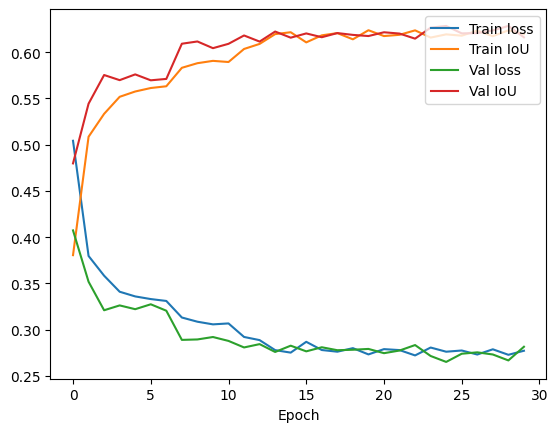

In [23]:
## Unet effb4 batch size 16 lr 0.001 argumentation
## Model inItialization
model = model.to(device)
metric_UNet = MeanIoU()
criterion_UNet = MultiDiceLoss()
optimizer_UNet = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler_UNet = lr_scheduler.StepLR(optimizer_UNet, step_size=7, gamma=0.1)

# Trainer
trainer = Trainer(model=model,
                  dataloaders=dataloaders,
                  epochs=30,
                  metric=metric_UNet,
                  criterion=criterion_UNet,
                  optimizer=optimizer_UNet,
                  scheduler=exp_lr_scheduler_UNet,
                  save_dir="UNet_Model_Output",
                  device=device)

## Training process
model_results = trainer.train_model()

## **Evaluation on Testset**

In [25]:
model_state = torch.load(r'D:\Tamanna Python\venv\Scripts\Semantic Segmentation\UNet_Model_Output\model_epoch_30')
model.load_state_dict(model_state)

C:\Users\neels\AppData\Local\Temp\ipykernel_31012\2076457252.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(r'D:\Tamanna Python\venv\Scripts\Se

<All keys matched successfully>

In [26]:
## Model inItialization
# model = model.to(device)
metric_DeepLab_V3 = MeanIoU()
criterion_DeepLab_V3 = MultiDiceLoss()
optimizer_DeepLab_V3 = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler_DeepLab_V3 = lr_scheduler.StepLR(optimizer_DeepLab_V3, step_size=7, gamma=0.1)

In [27]:
outputs = evaluate_model(model=model, dataloaders=dataloaders['val'],
                           metric=metric_DeepLab_V3, criterion=criterion_DeepLab_V3,
                           device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5834186..2.9256742].


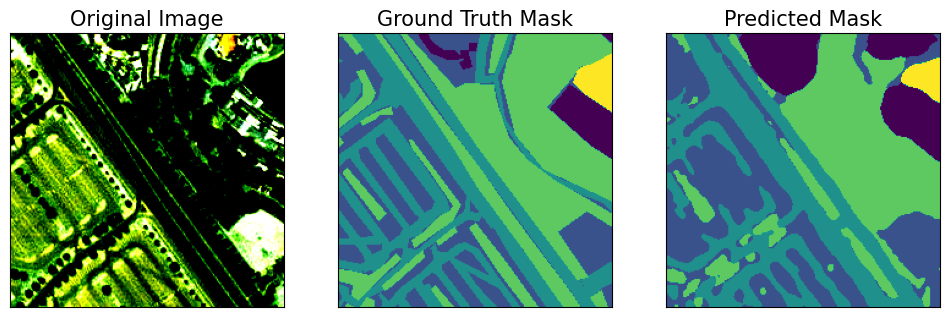

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6686769..2.9256742].


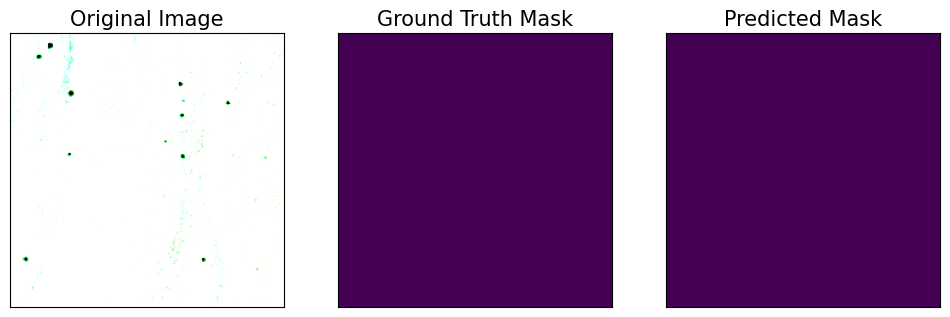

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5834186..2.9256742].


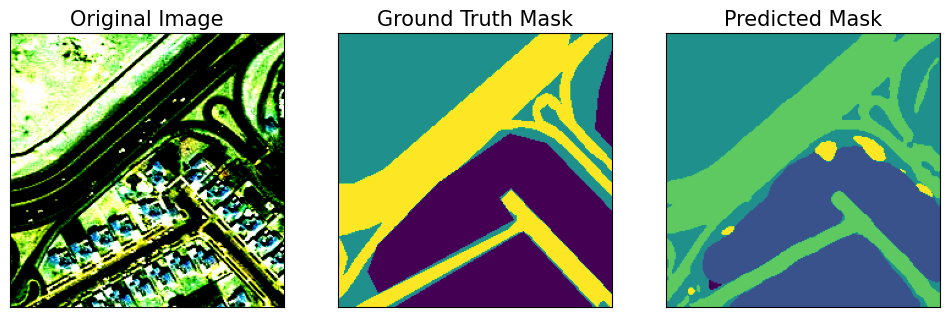

In [28]:
for idx in range(3):
    original_image = np.transpose(images[idx])
    ground_truth_mask = np.transpose(np.argmax(masks[idx], axis=0, keepdims=True))
    res = predict_mask(img=images, model=model, device=device)
    predicted_mask = np.transpose(np.argmax(res[idx].to('cpu'), axis=0, keepdims=True))
    display(original_image=original_image, ground_truth_mask=ground_truth_mask, predicted_mask=predicted_mask)